In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns




In [6]:
datasets = ['FGADR', 'RETLES', 'DDR', 'MESSIDOR', 'IDRID']
lesions = ['Cotton_Wool_Spot', 'Exudates', 'Hemorrhages', 'Microaneurysms']

stats_idrid = pd.read_pickle('idrid_global.pkl')
stats_messidor = pd.read_pickle('messidor_global.pkl')
stats_fgadr = pd.read_pickle('fgadr_global.pkl')
stats_retles = pd.read_pickle('retles_global.pkl')
stats_ddr = pd.read_pickle('ddr_global.pkl')

stats_idrid['Dataset'] = 'IDRID'
stats_messidor['Dataset'] = 'MESSIDOR'
stats_fgadr['Dataset'] = 'FGADR'
stats_retles['Dataset'] = 'RETINAL_LESIONS'
stats_ddr['Dataset'] = 'DDR'



all_dfs = dict(FGADR=stats_fgadr, RETLES=stats_retles, DDR=stats_ddr, MESSIDOR=stats_messidor, IDRID=stats_idrid)

/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


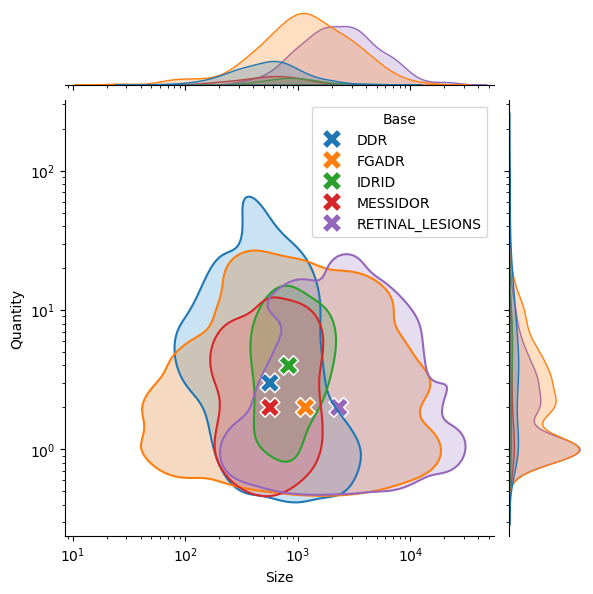

/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


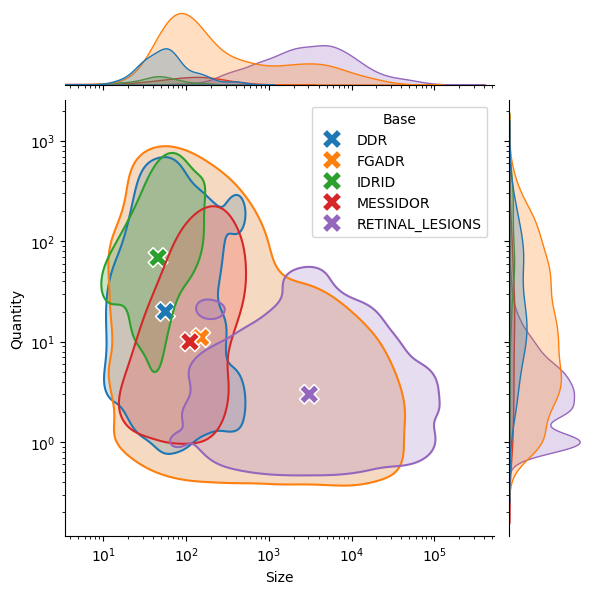

/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


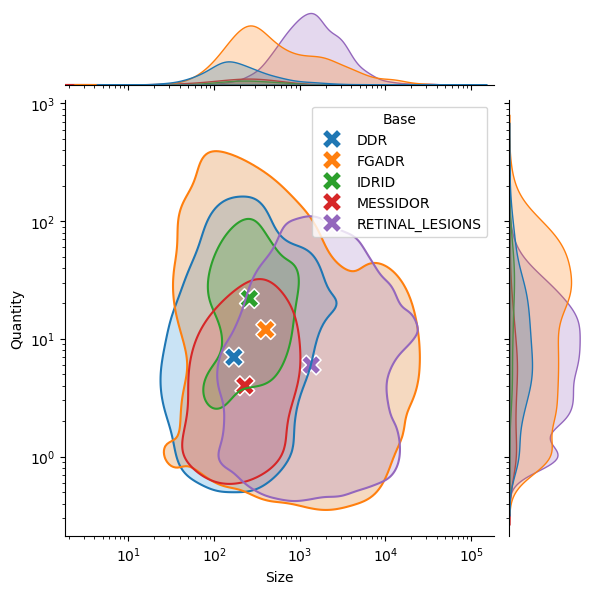

/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usagers/clpla/.conda/envs/torch18/lib/python3.9/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'kind'
  cset = contour_func(


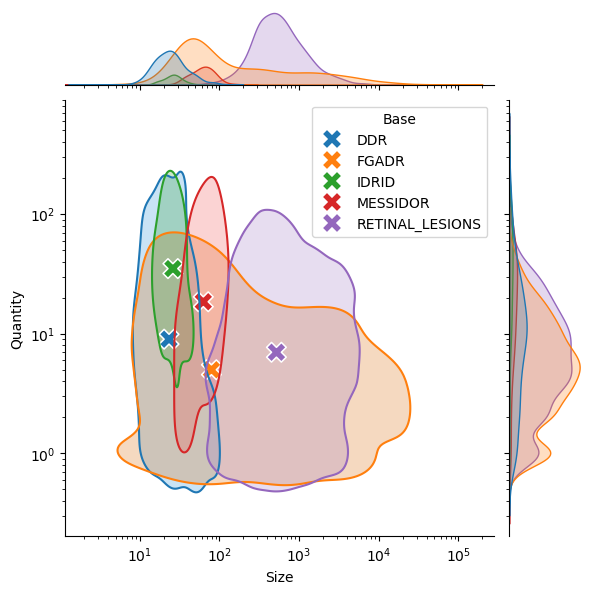

In [12]:
def get_lesions_size_as_dict(dfs, lesion):
    return {k:np.concatenate(data[f'{lesion}_size'].values) for k, data in dfs.items()}

lesions_size = get_lesions_size_as_dict(all_dfs, lesions[0])

def dataframe_from_lesions_size(lesions_size):
    dfs = []
    for k, v in lesions_size.items():
        df = pd.DataFrame.from_dict(dict(lesion_size=v, Datasett=k))
        dfs.append(df)
    return pd.concat(dfs)

def average_count_number_image(df, col):
    mean_values = [np.mean(_) for _ in df[col].values]
    count_values = [len(_) for _ in df[col].values]
    return pd.DataFrame(dict(Size=mean_values, Quantity=count_values, Base=df['Dataset'].values))

for l in lesions:
    pds = pd.concat([average_count_number_image(df, f'{l}_size') for df in all_dfs.values()])
    pds.dropna(axis=0, inplace=True)
    pds.sort_values(by='Base', inplace=True)
    g = sns.jointplot(pds, x="Size", y="Quantity", hue="Base",
                      log_scale=(True, True), kind="kde", 
                      levels=2, fill=True,
                      joint_kws = dict(alpha=0.1), 
                     )
    g.plot_joint(sns.kdeplot, log_scale=(True, True), hue="Base", kind="kde", levels=2)
    pd_mean = pds.groupby(['Base']).median()
    pd_mean.sort_index(inplace=True)
    sns.scatterplot(x=pd_mean['Size'], y=pd_mean['Quantity'], hue=pd_mean.index, marker='X', s=2e2)
    plt.savefig(f'distributions/{l}.png')
    plt.show()